# Random Feature Approximations for Scalable Sampling from GPs
October 2017
> Written for GPflow commit 874a0b7b307d4e9b1f3f2f723a3af824e3a6b4b2

> Run in Docker tensorflow/tensorflow:1.3.0-py3 image.

Sampling from a regular GP involves finding the Choleksy decomposition of the covariance matrix between the N points one wants to sample the function at. This is a $\mathcal{O}(N^3)$ operation. Techniques such as Thompson sampling wish to find the minimum (or maximum) of the sampled function, and during the optimisation process N can become very large. This motivates moving back to a weight space view (Rasmussen, C.E. and Williams, C.K., 2006) for kernels, such as the linear kernel, where the feature space is of low dimension.

For kernels with large (or even infinite) corresponding feature spaces we cannot use the actual feature space, as this costs more to evaluate than the kernel.
Rahimi, A. and Recht, B. (2008) showed how one can approximate stationary kernels with a low dimension feature space. Hernández-Lobato, J.M., Hoffman, M.W. and Ghahramani, Z. (2014) use such a technique to perform scalable sampling of the maxima/minima locations of a Gaussian process for kernels such as the RBF. In this document we show how one can implement this technique in GPflow. A good reference for this notebook implementation would be Section 2.1 and Appendix A of Hernández-Lobato, J.M., Hoffman, M.W. and Ghahramani, Z. (2014).

## Sampling draws from a GP
We will begin by comparing sampling the GP directly and doing it via the random features approach.
We first need a dataset to train a GP on. We create this below.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import linalg as sla
from scipy import optimize

import gpflow
from gpflow import decors

NUM_OBS = 200
AXIS_EDGE = 0.5
NOISE_STD = 0.05

def func1(x):
    """
    this is the function we wish to plot.
    """
    f = np.sin(12 * x) + 0.66 * np.cos(25 * x)
    return f

def create_random_x_data(rng):
    """
    We sample random points to form our dataset, 
    as well as gridding up the input space as this is
    where we will make our predictions.
    """
    x_data = rng.rand(NUM_OBS, 1)  # make it as a column vector
    x_axis_indcs = np.linspace(x_data.min() - AXIS_EDGE, x_data.max() + AXIS_EDGE, 150)[:, None]
    return x_data, x_axis_indcs


def package_data(x_data, x_axis_idcs, rng):
    """
    We create a function to store the data in a dictionary
    """
    f_data = func1(x_data)

    data = dict(
        x_axis=x_axis_idcs,
        x_data=x_data,

        f=f_data,
    )
    data['y'] = data['f'] + NOISE_STD * rng.randn(*data['f'].shape)
    return data

%matplotlib inline

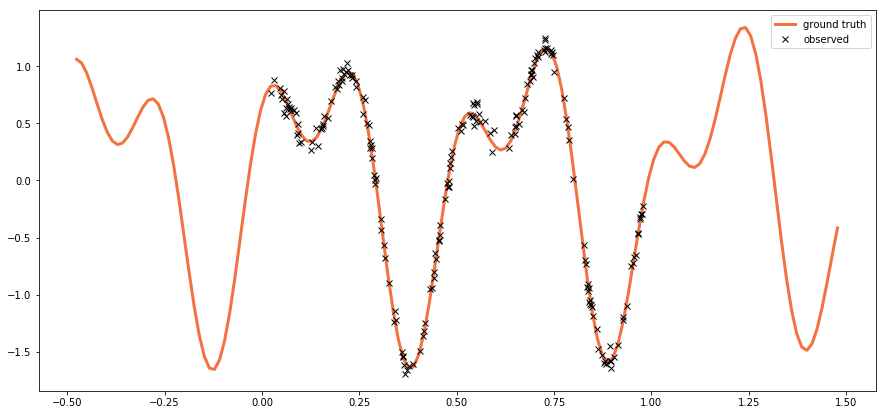

In [2]:
rng = np.random.RandomState(3)
x_data, x_axis_points = create_random_x_data(rng)
data = package_data(x_data, x_axis_points, rng)

# We will now plot the true func as well as the observations we receive.
f, ax = plt.subplots(figsize=(15, 7))
plt.plot(x_axis_points, func1(x_axis_points), color='#f47142', lw=3, label="ground truth")
plt.plot(x_data, data['y'], 'kx', label="observed")
plt.legend()
plt.show()

We now setup our GP and train it on this dataset.

In [3]:
kernel = gpflow.kernels.RBF(1)
kernel.lengthscales = 0.1
model = gpflow.models.GPR(data['x_data'], data['y'], kern=kernel)
model.compile()
optimizer = gpflow.train.ScipyOptimizer(options=dict(maxiter=100))
optimizer.minimize(model)
print("The model has been trained and its log likelihood is {}".format(model.compute_log_likelihood()))

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -243.558534
  Number of iterations: 16
  Number of functions evaluations: 23
The model has been trained and its log likelihood is 243.55853354851388


We now sample from this trained GP two times for each approach.

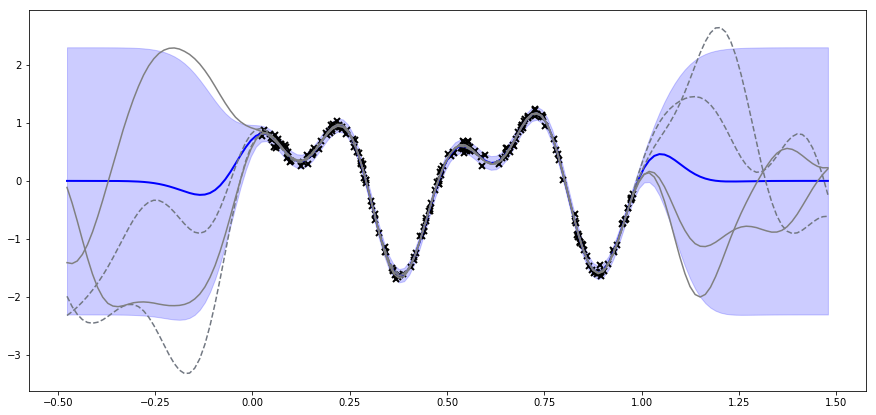

In [4]:
# =====
# 1.We will first begin by plotting the observations and the GP predictions
mean, var = model.predict_y(x_axis_points)
f, ax = plt.subplots(figsize=(15, 7))
ax.plot(x_data, data['y'], 'kx', mew=2)
ax.plot(x_axis_points, mean, 'b', lw=2)
ax.fill_between(x_axis_points[:, 0], mean[:, 0] - 2 * np.sqrt(var[:, 0]),
                mean[:, 0] + 2 * np.sqrt(var[:, 0]), color='blue', alpha=0.2)


# =====
# 2. We now sample via the random features approach.
def approx_features_func(X):
    return model.kern.feature_map(X)

# For the GPR class there is a autoflow method that provides what would be the weights posterior if 
# these random weights were those that described the datapoints and we were doing Bayesian linear regression
mean, precision_or_var, var_flag = model.linear_weights_posterior()
L = sla.cholesky(precision_or_var, lower=True)

for j in range(2):
    # Below we check whether we have been given a variance or precision matrix back and act accordingly.
    if var_flag:
        sampled_var = (L @ rng.randn(mean.shape[0]))[:, None]
    else:
        sampled_var = sla.solve_triangular(L.T, rng.randn(mean.shape[0]), lower=False)[:, None]
    theta_sample = mean + sampled_var

    phi_at_xindcs = approx_features_func(x_axis_points)
    f_sample = phi_at_xindcs @ theta_sample
    plt.plot(x_axis_points, f_sample, '--', color='#727882', label="approx_{}".format(j))

    
# =====
# 3. Finally we sample from the GP exactly without approximating the kernel
# there is an inbuilt GPflow command for doing this which we will use
for i, m in enumerate(model.predict_f_samples(x_axis_points, 2)):
    plt.plot(x_axis_points, m, 'gray', label="actual_{}".format(i))
    
plt.show()

Can you tell the difference? The grey dotted lines have come from the approximated kernel via random features route whereas the solid grey lines are samples from the exact GP. The dark blue line is the posterior mean of the exact GP and the light blue region shows 2 std deviations either side. The black crosses are the datapoints we train on.

## Using the random samples for Thompson Sampling
We now use these samples from the GP for Thompson Sampling. Note that we can work out the derivatives of samples even when derivatives are not defined for the kernel we are approximating. These derivatives can be fed into certain optimisers to help it find minima.

We will first define a function that can create a function to return the sample's value and sample's derivative value at a particular point.


In [5]:
def _create_approx_func_with_grads(model, data_dim, theta):
    """
    This provides a function that
    evaluates the sampled function's (defined by the provided theta, ie sampled weights,) value 
    and the gradient of this value with respect to the inputs.
    """
    tf_graph = model.graph
    tf_sess = model.session

    with tf_graph.as_default():
        x_ph = tf.placeholder(tf.float64, [None, data_dim])

        previous_unitialised_vars = decors._get_set_of_unit_var_names(model.session)
        feats = model.kern._feature_map(x_ph)
        func = tf.matmul(feats, theta)
        func_deriv = tf.gradients(func, x_ph)

        # We then see if this has created any new variables and initialise these.
        current_unitialised_vars = decors._get_set_of_unit_var_names(model.session)
        model.session.run(tf.variables_initializer(
            decors._collect_vars_with_name(current_unitialised_vars - previous_unitialised_vars)
        ))


    def approx_func(X):
        X = np.atleast_2d(X)
        fd = {x_ph:X}
        if model.feeds:
            fd.update(model.feeds)
        func_evald, deriv_evald = tf_sess.run([func, func_deriv],
                                              feed_dict=fd)
        return func_evald[0].astype(np.float64), deriv_evald[0].astype(np.float64)

    return approx_func

The variable `theta` to this function should be the linear weights sampled from the posteror over the weights. We already did this for the sampling demonstration above but below we will create a function that wraps this operation for us.

In [6]:
def create_sampling_function(model, rng):
    mean, precision_or_var, var_flag = model.linear_weights_posterior()
    L = sla.cholesky(precision_or_var, lower=True)
    def sample_theta():
            if var_flag:
                sampled_var = (L @ rng.randn(mean.shape[0]))[:, None]
            else:
                sampled_var = sla.solve_triangular(L.T, rng.randn(mean.shape[0]), lower=False)[:, None]

            theta_sample = mean + sampled_var
            return theta_sample
    return sample_theta
        
sampling_function = create_sampling_function(model, rng)
# ^ we will create this on the same model we were using before

We will now demonstrate how this can be used to find a minimum from the sample. We show how to use two possible optimisers but more can also be used depending on how important it is to find a global rather than local minimum and how quick we want the optimisation to take.

In [7]:
# Create sample and the function that evaluates this sample and gradient at a point
theta_sample = sampling_function()
f_sampler = _create_approx_func_with_grads(model, x_data.shape[1], theta_sample)

# Now use this function to find the minimum of the sample
initial_sample = np.array([rng.choice(x_data.flatten())])[:, None]
opt_res_lbfgsb = optimize.minimize(lambda x: f_sampler(x), x0=initial_sample, method="L-BFGS-B",
                            jac=True, bounds=[(x_axis_points.min(), x_axis_points.max())])

# We can also use different optimizers which may be better at finding the global minimum.
class Bounds:
    def __init__(self, min_v, max_v):
        self.min = min_v
        self.max = max_v
        
    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        return np.all(self.min <= x <= self.max)
opt_res_basin = optimize.basinhopping(lambda x: f_sampler(x)[0], initial_sample, niter=200, accept_test=Bounds(x_axis_points.min(), x_axis_points.max()))

We can now plot these results.

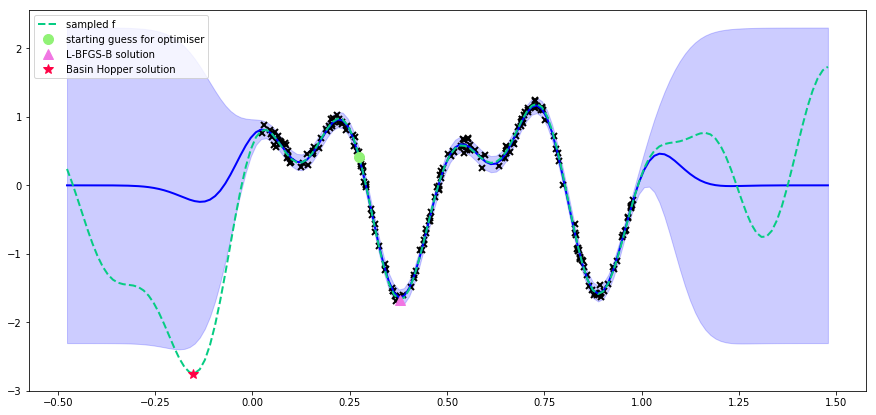

In [8]:
# We will first begin by plotting the observations and the GP predictions
mean, var = model.predict_y(x_axis_points)
f, ax = plt.subplots(figsize=(15, 7))
ax.plot(x_data, data['y'], 'kx', mew=2)
ax.plot(x_axis_points, mean, 'b', lw=2)
ax.fill_between(x_axis_points[:, 0], mean[:, 0] - 2 * np.sqrt(var[:, 0]),
                mean[:, 0] + 2 * np.sqrt(var[:, 0]), color='blue', alpha=0.2)

# We will then plot the sample
sampled_f = np.apply_along_axis(lambda x: f_sampler(x)[0], 1, x_axis_points)
plt.plot(x_axis_points, sampled_f, '--', lw=2, color='#06cc83', label="sampled f")
plt.plot(initial_sample, f_sampler(initial_sample)[0], 'o', ms=10, label='starting guess for optimiser', color='#91f276')
plt.plot(opt_res_lbfgsb.x, f_sampler(opt_res_lbfgsb.x)[0], '^', ms=10, label='L-BFGS-B solution', color='#f176e3')
plt.plot(opt_res_basin.x, f_sampler(opt_res_basin.x)[0], '*', ms=10, label='Basin Hopper solution', color='#ff0245')
plt.legend()
plt.show()

So in the figure above we plot the posterior of the actual GP in blue similar to before. The observerd data points are shown as black crosses. We then sample from this posterior via the random features approach. This is shown as the dotted green line. We then wish to find the minima of this. We try two optimisers both starting from the initial point shown by the green circle. The L-BFGS-B finds an alternative local minimum. The Basin Hopping algorithm finds the global minimum of the sample within the bounds. This algorithm is designed for global minima so this is not unsuprising.

We can also query the optimiser results to find how many function evaluations each took. This is done below (Note that  L-BFGS-B will also use gradients). See how the Basin Hopping algorithm needs many function evaluations. The fact that the sampling time no longer scales as $\mathcal{O}(N^3)$ with the number of samples is useful for allowing this method to work quickly!

In [9]:
print("L-BFGS-B took {} function evaluations".format(opt_res_lbfgsb.nfev))
print("Basin hopping took {} function evaluations".format(opt_res_basin.nfev))

L-BFGS-B took 10 function evaluations
Basin hopping took 5547 function evaluations
